https://ochem.eu/static/challenge.do

# TOX24

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from rdkit import Chem
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt

In [3]:
datafile = pd.read_csv("tox24_challenge_train.csv")

(array([  5.,  20.,  60., 292., 148., 109.,  89.,  64.,  88., 131.]),
 array([-45.  , -29.39, -13.78,   1.83,  17.44,  33.05,  48.66,  64.27,
         79.88,  95.49, 111.1 ]),
 <BarContainer object of 10 artists>)

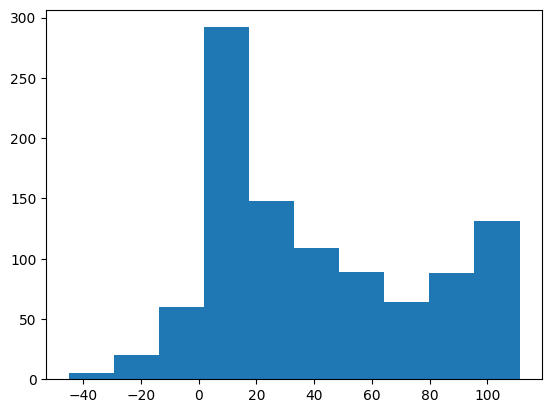

In [4]:
plt.hist(datafile.activity)

In [5]:
def cat(num):
    if num <= 0:
        return 0 #negative
    elif num>0 and num < 30:
        return 1 #neutral
    else:
        return 2 #positive

In [6]:
datafile["cat"] = datafile["activity"].apply(cat)

In [7]:
datafile

,SMILES,activity,cat
0,CC1(C)[C@@H]2C[C@H]1C(=C)CC2,12.3,1
1,COC(=O)C(C)OC1=CC=C(OC2=CC=C(Cl)C=C2Cl)C=C1,94.1,2
2,CCCCCCCCCCCCCC(=O)OCC(O)CO,38.1,2
3,CC(=O)O[C@@H]1C[C@@H]2CC[C@@]1(C)C2(C)C,11.8,1
4,CCCCCCCCCC=CCC1CC(=O)OC1=O,98.4,2
...,...,...,...
1001,COC1=C(OC)C(=CC=C1)[C@H](O)C2CCN(CCC3=CC=C(F)C...,-16.9,0
1002,CC(=O)CC(C1=CC=CC=C1)C2=C(O)C3=CC=CC=C3OC2=O,93.2,2
1003,C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(O)=CC(O)=C2)C(=O)O1,28.1,1
1004,OC(=O)CN1C(=O)N(CC2=CC=C(Br)C=C2F)C(=O)C3=C1C=...,59.0,2


In [8]:
smiles_list = datafile["SMILES"].to_list()
activity_values = datafile["cat"].to_list()

In [27]:
class GATNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, global_feature_dim, dropout):
        super(GATNet, self).__init__()

        self.conv1 = GATConv(in_channels, hidden_channels, heads=10, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * 10, hidden_channels, heads=8, dropout=dropout)
        self.conv3 = GATConv(hidden_channels * 8, hidden_channels, heads=2, dropout=dropout)
        graph_feature_dim = hidden_channels * 2
        self.fc = nn.Linear(graph_feature_dim + global_feature_dim, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = data.edge_attr if hasattr(data, "edge_attr") else None  
        
        global_features = data.global_features  
        global_features = global_features.to(x.device)  


        x = self.conv1(x, edge_index, edge_attr)
        x = F.tanh(x)
        
        x = self.conv2(x, edge_index, edge_attr)
        x = F.tanh(x)
        
        x = self.conv3(x, edge_index, edge_attr)
        x = F.tanh(x)

        x = global_mean_pool(x, batch)
        x = torch.cat([x, global_features], dim=1)

        return self.fc(x)

In [28]:
from rdkit.Chem import Descriptors, rdMolDescriptors

In [29]:
def compute_molecular_descriptors(mol):
    return torch.tensor([
        Descriptors.MolWt(mol),
        Descriptors.HeavyAtomMolWt(mol),
        Descriptors.ExactMolWt(mol),
        Descriptors.FractionCSP3(mol),
        Descriptors.MolLogP(mol),
        Descriptors.BertzCT(mol),
        rdMolDescriptors.CalcLabuteASA(mol),
        rdMolDescriptors.CalcNumAromaticRings(mol),
        rdMolDescriptors.CalcNumAromaticCarbocycles(mol)
    ], dtype=torch.float)

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    x = []
    for atom in mol.GetAtoms():
        x.append([
            atom.GetAtomicNum(),  
            atom.GetDegree(),  
            atom.GetHybridization().real, 
            int(atom.GetIsAromatic()),  
            atom.GetFormalCharge(),  
            atom.GetChiralTag().real  
        ])
    
    x = torch.tensor(x, dtype=torch.float)

    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        
        bond_feature = [
            bond.GetBondTypeAsDouble(),  
            int(bond.GetIsConjugated()), 
            int(bond.IsInRing())  
        ]

        edge_index.append((i, j))
        edge_index.append((j, i))
        edge_attr.append(bond_feature)
        edge_attr.append(bond_feature)

    if edge_index:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 3), dtype=torch.float)  

    global_features = compute_molecular_descriptors(mol).unsqueeze(0)  #(1, num_features)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, global_features=global_features)

In [30]:
graph_data = []
for s, y in zip(smiles_list, activity_values):
    graph = smiles_to_graph(s)
    if graph is not None:
        graph.y = torch.tensor([y], dtype=torch.float)
        graph_data.append(graph)

In [31]:
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

In [32]:
dataloader = DataLoader(graph_data, batch_size=500, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


global_feature_dim = graph_data[0].global_features.shape[1]
model = GATNet(in_channels=graph_data[0].x.shape[1], hidden_channels=512, num_classes=3, 
               global_feature_dim=global_feature_dim, dropout=0.5).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=7, verbose=True)
loss_fn = nn.CrossEntropyLoss()

epochs = 10
best_accuracy = 0.0  
best_loss = float("inf") 
best_model_state = None  

for epoch in range(epochs):
    total_loss = 0
    model.train()
    correct, total = 0, 0

    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()

        output = model(batch)
        loss = loss_fn(output, batch.y.long())

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = output.argmax(dim=1)
        #print(preds)
        correct += (preds == batch.y.long()).sum().item()
        total += batch.y.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    scheduler.step(avg_loss)

    if accuracy > best_accuracy:  
        best_accuracy = accuracy
        best_loss = avg_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


model.load_state_dict(best_model_state)
print(f"\nBest Model Performance: Loss: {best_loss:.4f}, Accuracy: {best_accuracy:.4f}")

Epoch 1/10, Loss: 5.6667, Accuracy: 0.5487
Epoch 2/10, Loss: 3.2839, Accuracy: 0.4036
Epoch 3/10, Loss: 2.0942, Accuracy: 0.4771
Epoch 4/10, Loss: 1.9171, Accuracy: 0.4692
Epoch 5/10, Loss: 1.6526, Accuracy: 0.4423
Epoch 6/10, Loss: 2.4071, Accuracy: 0.4334
Epoch 7/10, Loss: 1.3988, Accuracy: 0.5199
Epoch 8/10, Loss: 1.8672, Accuracy: 0.5189
Epoch 9/10, Loss: 1.9127, Accuracy: 0.5239
Epoch 10/10, Loss: 1.4930, Accuracy: 0.4821

Best Model Performance: Loss: 5.6667, Accuracy: 0.5487


In [51]:
print(model)

GATNet(
  (conv1): GATConv(6, 512, heads=10)
  (conv2): GATConv(5120, 512, heads=5)
  (conv3): GATConv(2560, 512, heads=2)
  (fc): Linear(in_features=1033, out_features=3, bias=True)
)


In [52]:
print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

Epoch 20/20 | Loss: 0.8456 | Accuracy: 0.6481


In [ ]:
#old

In [39]:
print(model)

GATNet(
  (conv1): GATConv(6, 512, heads=10)
  (conv2): GATConv(5120, 512, heads=5)
  (fc): Linear(in_features=2569, out_features=3, bias=True)
)


In [40]:
print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

Epoch 10/10 | Loss: 0.8067 | Accuracy: 0.6600


In [ ]:
class GATNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, global_feature_dim, dropout=0.5):
        super(GATNet, self).__init__()

        self.conv1 = GATConv(in_channels, hidden_channels, heads=10, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * 10, hidden_channels, heads=5, dropout=dropout)

        graph_feature_dim = hidden_channels * 5
        self.fc = nn.Linear(graph_feature_dim + global_feature_dim, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = data.edge_attr if hasattr(data, "edge_attr") else None  
        
        global_features = data.global_features  
        global_features = global_features.to(x.device)  


        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)

        x = global_mean_pool(x, batch)
        x = torch.cat([x, global_features], dim=1)

        return self.fc(x)